## Семинар 8: "Снижение размерности"

ФИО: Пензар Дмитрий Дмитриевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import seaborn as sbn

import numpy as np
import sys
from timeit import default_timer as timer

import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import ticker
from collections import namedtuple
import gc


%matplotlib inline

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sbn.set_style("dark")

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [3]:
dataset = fetch_olivetti_faces()
X = dataset['data']

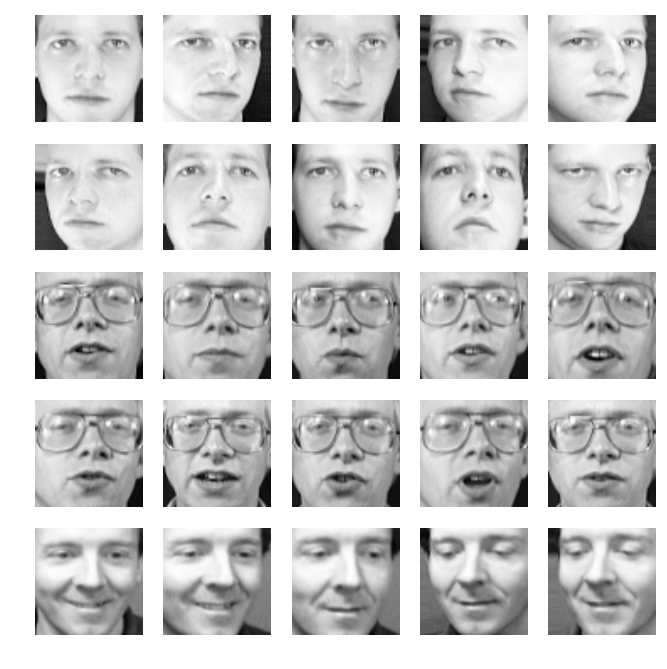

In [4]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [5]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

In [6]:
def get_pca(n_components, X):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    return pca

def test_pca(X_train, X_test, n_components):
    pca = get_pca(n_components, X_train)
    X_train_new = pca.inverse_transform(pca.transform(X_train))
    X_test_new = pca.inverse_transform(pca.transform(X_test))
    return np.sqrt(np.square(X_train-X_train_new).sum(axis = 1)).mean(),\
        np.sqrt(np.square(X_test-X_test_new).sum(axis = 1)).mean()

In [7]:
#X_train, X_test = train_test_split()
X_train, X_test = train_test_split(X, test_size=0.2)

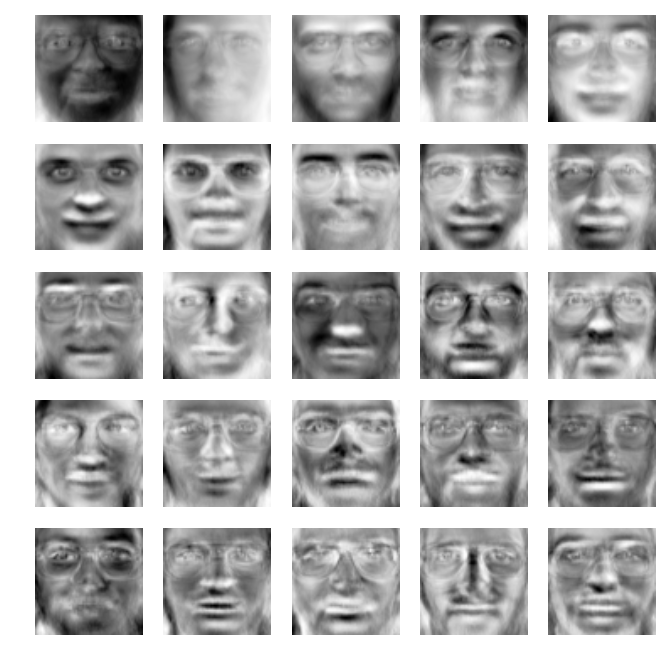

In [10]:
pca = get_pca(25, X)
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>
Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [75]:

N_min = 2
N_max = 300
train_quality = np.zeros( (N_max - N_min + 1) )
test_quality = np.zeros( (N_max - N_min + 1) )

for i, N in enumerate(range(N_min, N_max + 1)):
    tr, te = test_pca(X_train, X_test, N)
    train_quality[i], test_quality[i] = tr, te

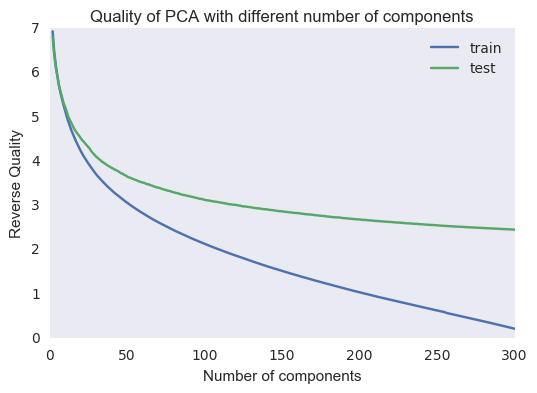

In [77]:
plt.plot(range(N_min, N_max + 1), train_quality, label = "train")
plt.plot(range(N_min, N_max + 1), test_quality, label = "test")
plt.title("Quality of PCA with different number of components")
plt.xlabel("Number of components")
plt.ylabel("Reverse Quality")
plt.legend()
plt.show()

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

Видим, что  где-то в районе 100 компонент мы перестали улучшать результат на трайне, переобучаясь на тесте. 
Оптимум между размерностью и балансом, по-видимому, находится в районе 50 компонент

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [8]:
##thanks to dm1
def plot_dataset(dataset, x, y, margin=50, frame=2000., imsize=64):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    image = np.zeros((x1.max() + margin + imsize, y1.max() + margin + imsize)) + 1
    print "Image size is %dx%d" % image.shape
    for k in xrange(dataset.images.shape[0]):
        image[x1[k]:x1[k]+64, y1[k]:y1[k]+64] = dataset.images[k]
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()


/Users/penzardmitry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/penzardmitry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Image size is 2164x2164


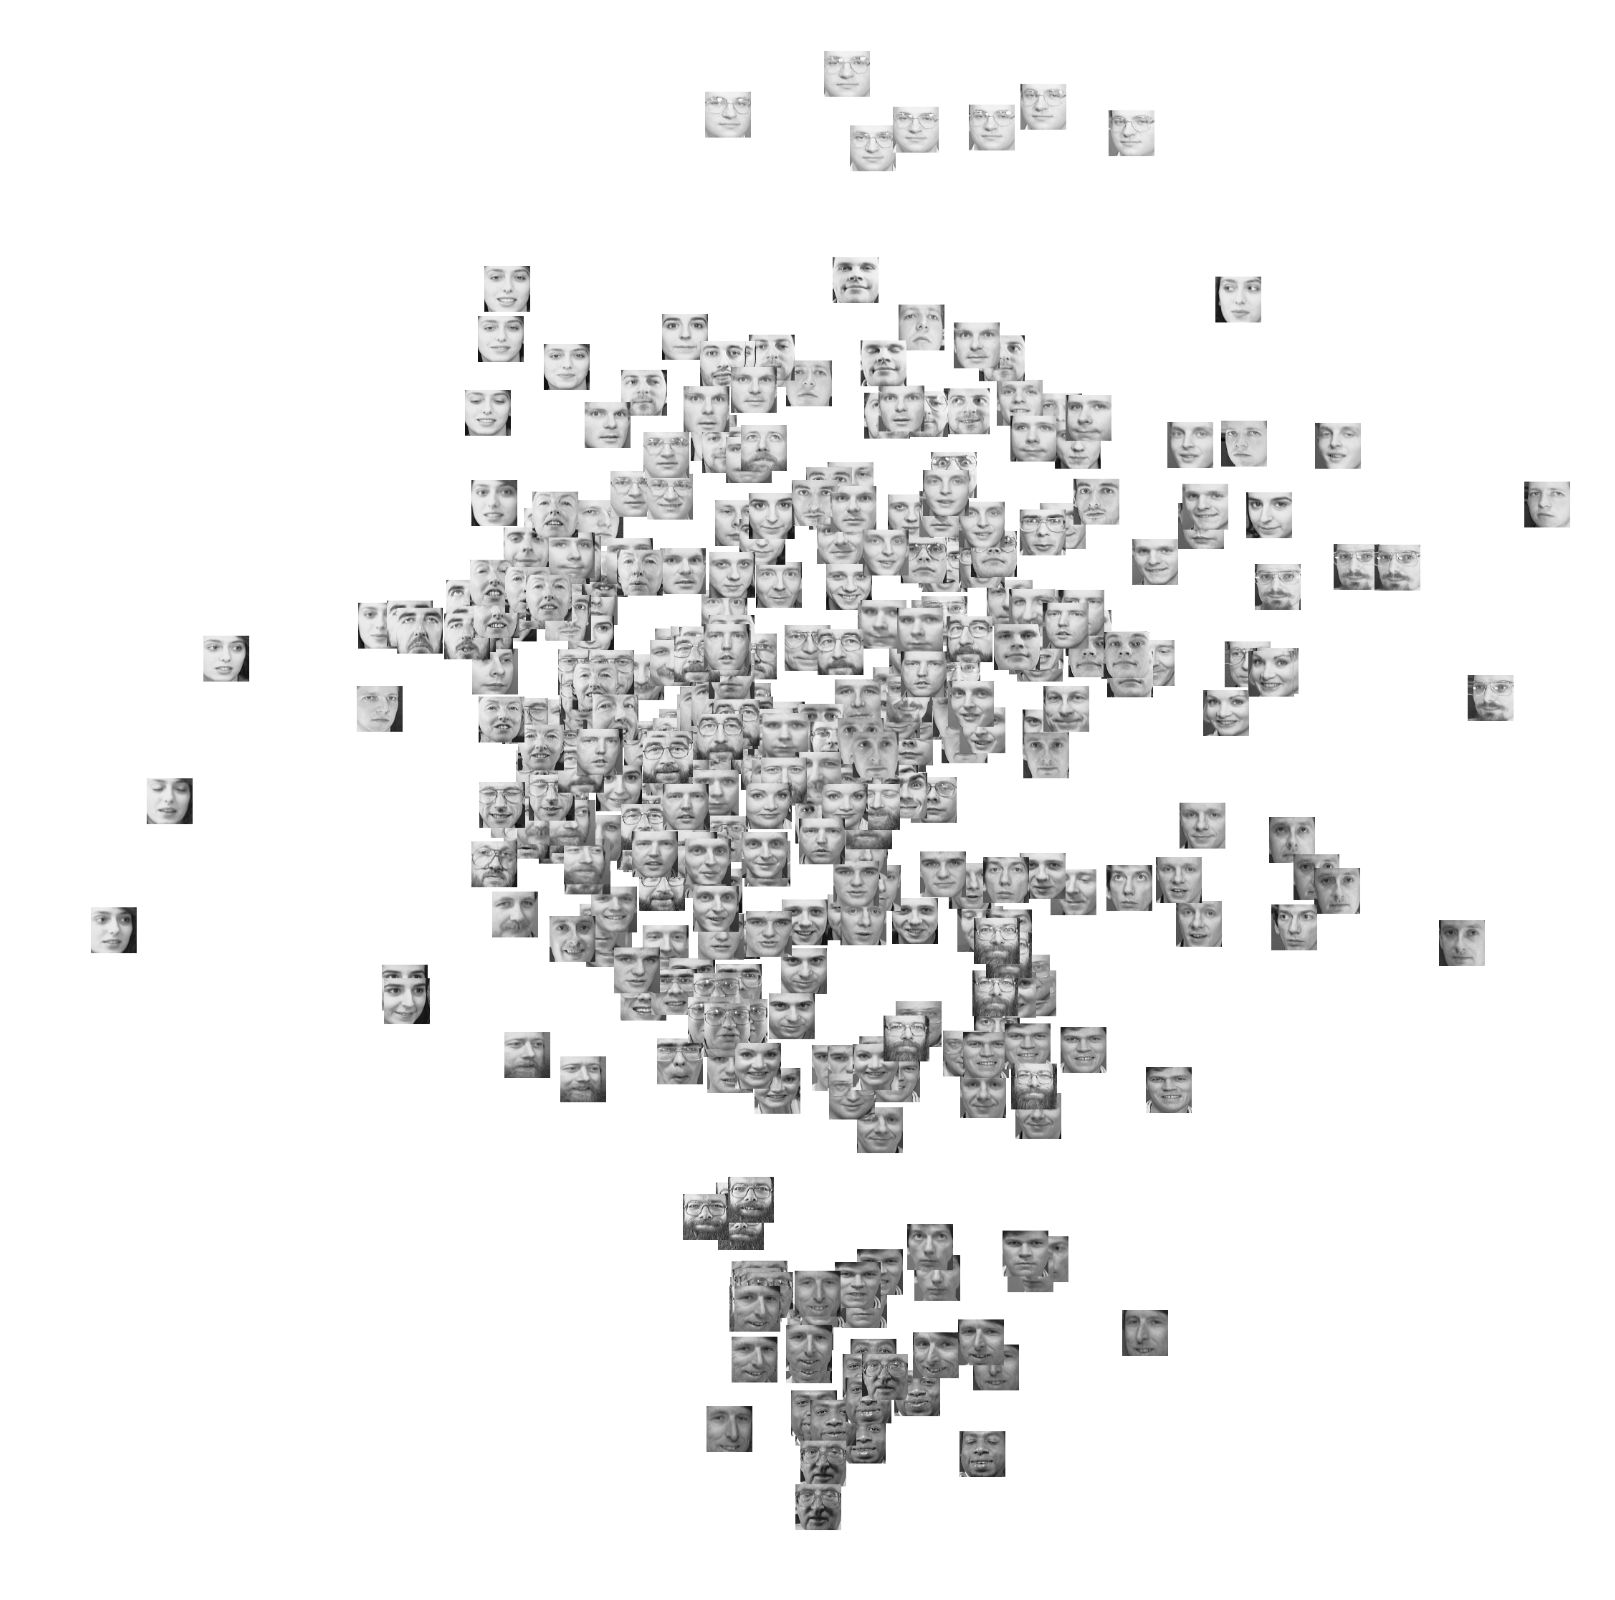

In [93]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
plot_dataset(dataset, coords[:, 0], coords[:, 1])

Отчетливо выделился кластер с изображением лиц одного человека (вверху изображения), и еще два кластера с не совсем понятным принципом разделения

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [9]:
class Autocoder(nn.Module):
    def __init__(self, first_dim, center_dim):
        super(Autocoder, self).__init__()
        self.coder = nn.Sequential(
            nn.Linear(4096, first_dim),
            nn.Sigmoid(),
            nn.Linear(first_dim, center_dim),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(center_dim, first_dim),
            nn.Sigmoid(),
            nn.Linear(first_dim, 4096)
        )

        
    def forward(self, x):
        x = self.coder(x)
        x = self.decoder(x)
        return x

In [10]:
#was copied from previous homework
def print_work_time(func):
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print("Execution take {}".format(end - start))
        return result
    return wrapper

@print_work_time
def learn_on_model(X, Y, model, loss_fn, optimizer, X_test = None, Y_test = None, learning_rate = 1e-2, 
                   batch_size = 100, max_epoch_num = 1, min_loss = 1e-5):    
    loss = 1000
    epoch_num = 0
     
    loss_arr = list()

    test_loss_arr = list() if not (type(X_test) is None) else None
    tot_err = 10**6

    while epoch_num < max_epoch_num:
        model = model.eval()
        tot_err = 0
        #sys.stdout.write("\nEpoch {} ... \n".format(epoch_num + 1))
        #sys.stdout.write("Train\n")
        for bn, start in enumerate(xrange(0, X.shape[0], batch_size)):
            optimizer.zero_grad()
            if bn % 100 == 0:
                pass
                #sys.stdout.write("\rBatch {}".format(bn))
            X_CUR = Variable(torch.from_numpy(X[start:start + batch_size]).type(torch.FloatTensor),
                            requires_grad = True)
            Y_CUR = Variable(torch.from_numpy(Y[start:start + batch_size]), requires_grad=False)
            output =  model.forward(X_CUR)
            loss = loss_fn(output, Y_CUR)
            loss_arr.append(loss.data.tolist()[0])
            tot_err += loss.data.tolist()[0]
            loss.backward()
            optimizer.step()
            del loss
            del X_CUR
            del Y_CUR
            del output
        #sys.stdout.write("\nTest\n")
        if not (type(X_test) is None):
            model = model.train()
            for bn, start in enumerate(xrange(0, X_test.shape[0], batch_size)):
                if bn % 100 == 0:
                    pass
                    #sys.stdout.write("\rBatch {}".format(bn))
                X_CUR = Variable(torch.from_numpy(X_test[start:start + batch_size]).type(torch.FloatTensor),
                                requires_grad = True)
                Y_CUR = Variable(torch.from_numpy(Y_test[start:start + batch_size]), requires_grad = False)
                y_pred = model.forward(X_CUR)
                loss = loss_fn(y_pred, Y_CUR)
                test_loss_arr.append(loss.data.tolist()[0])
                del X_CUR
                del Y_CUR
                del y_pred
                del loss
        #sys.stdout.write("\n")   
        epoch_num += 1
        gc.collect() # only this've helped to save process from beeing kill
    model = model.train()
    return np.array(loss_arr), np.array(test_loss_arr)

def draw_plots(model, loss_arr, layer_arr, test_loss_arr, show_weights = False):
    x = np.arange(loss_arr.shape[0]);
    number_of_plots = 1 + sum(len(x) for x in layer_arr)
    gridSize = number_of_plots
    plt.figure(figsize=(15, 6 * number_of_plots))
    
    plotId = 1
    subpl = plt.subplot(gridSize, 1, plotId)
    if not type(test_loss_arr) is None:
        subpl.plot(x, loss_arr, x, test_loss_arr)
        subpl.legend(["Train", "Test"])
    else:
        subpl.plot(x, loss_arr)
    subpl.set_xticks(range(x.shape[0]))
    subpl.set_title("Loss function")
    subpl.set_xlabel("Epoch num")
    subpl.set_ylabel("Loss func")
    if show_weights:
        for ind1, child in enumerate(model.children()):
            for ind2, key in enumerate(child.state_dict().keys()):
                plotId += 1
                subpl = plt.subplot(gridSize, 1, plotId)
                y = layer_arr[ind1][ind2]
                subpl.plot(x, y)

                subpl.set_xticks(range(x.shape[0]))
                subpl.set_title("Layer {} : {} gradient norm".format(ind1 + 1, key))
                subpl.set_xlabel("Epoch num")
                subpl.set_ylabel(key + "_grad")
    
    plt.show()

from sklearn.metrics import classification_report

def make_classification_report(model, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST, batch_size = 100):
    model = model.eval()
    print ("Train report")
    y_predicted = np.zeros(shape = (Y_TRAIN.shape[0], 10))
    
    for bn, start in enumerate(xrange(0, X_TRAIN.shape[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(torch.from_numpy(X_TRAIN[start:start + batch_size]).type(torch.FloatTensor) )
        
        
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TRAIN.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TRAIN.tolist()) == indices))
    
    print ("Test report")
    y_predicted = np.zeros(shape = (Y_TEST.shape[0], 10))
    for bn, start in enumerate(xrange(0, X_TEST.shape[0], batch_size)):
        if bn % 100 == 0:
            sys.stdout.write("Batch {}\n".format(bn))
        X_CUR = Variable(torch.from_numpy(X_TEST[start:start + batch_size]).type(torch.FloatTensor))
        y_predicted[start:start + batch_size] = np.array(model.forward(X_CUR).data.tolist())
        del X_CUR
        
    
    
    indices = np.argmax(y_predicted, axis = 1)
    print (classification_report(np.array(Y_TEST.tolist()), indices))
    print ("Accuracy", np.mean(np.array(Y_TEST.tolist()) == indices))

    


In [11]:
def get_autocoder(X_train, X_test, first_dim = 200, center_dim = 10):
    model = Autocoder(first_dim=first_dim, center_dim=center_dim)

    loss_fn = torch.nn.MSELoss(size_average=True)
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # momentum, there is no nag
    loss_arr, test_loss_arr = learn_on_model(X_train, X_train, model, loss_fn, optimizer,\
                                                        X_test,\
                                                        X_test,\
                                                        learning_rate,\
                                                        max_epoch_num=50, batch_size = 32)
    plt.title("Center dim {}".format(center_dim))
    plt.plot(loss_arr)
    plt.show()
    return model

def test_autocoder(X_train, X_test, first_dim = 200, center_dim = 10):
    autocoder = get_autocoder(X_train, X_test, first_dim=first_dim, center_dim=center_dim)
    
    
    X_train_new = autocoder(Variable(torch.from_numpy(X_train).\
                                     type(torch.FloatTensor))).data.numpy()
    X_test_new = autocoder(Variable(torch.from_numpy(X_test).\
                                     type(torch.FloatTensor))).data.numpy()

    return np.sqrt(np.square(X_train-X_train_new).sum(axis = 1)).mean(),\
        np.sqrt(np.square(X_test-X_test_new).sum(axis = 1)).mean()

In [12]:
c_dim_arr = (2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100)
train_quality = np.zeros(len(c_dim_arr))
test_quality = np.zeros(len(c_dim_arr))


Execution take 29.2745449543


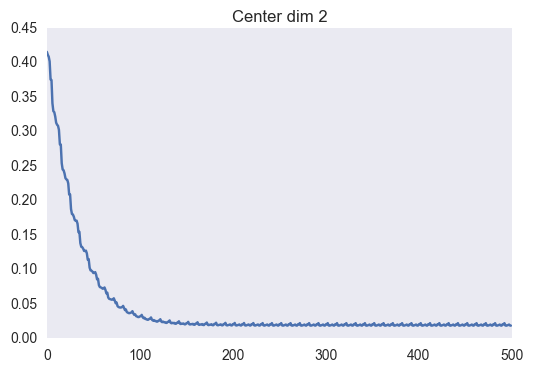

Execution take 22.5517539978


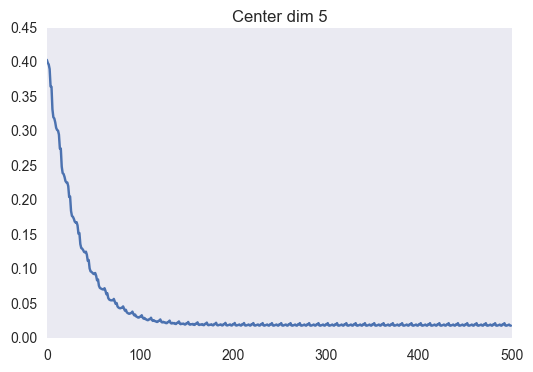

Execution take 24.0628159046


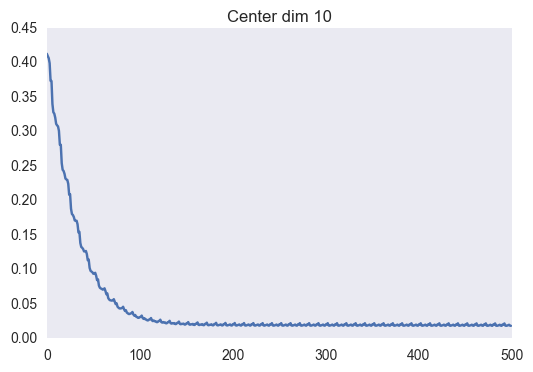

Execution take 23.3774559498


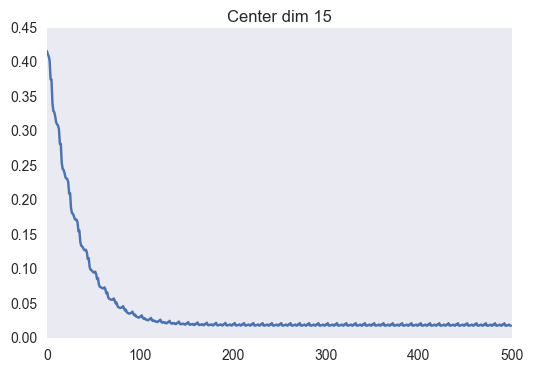

Execution take 23.2918899059


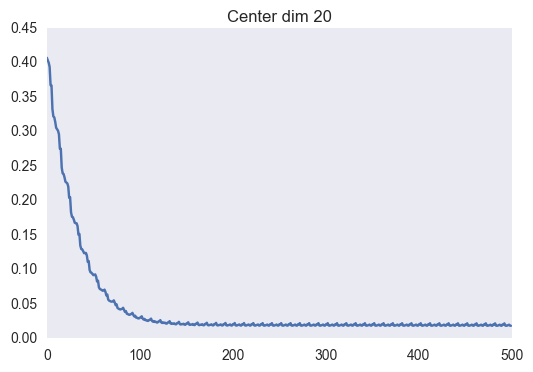

Execution take 24.4187688828


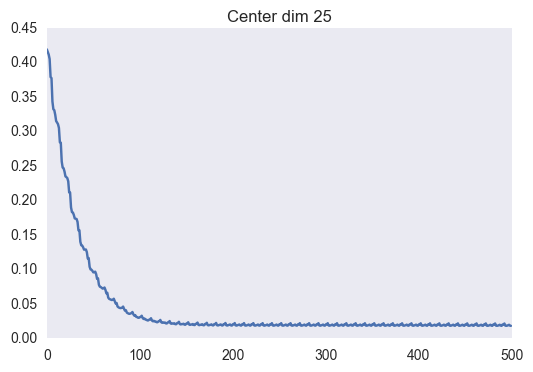

Execution take 30.0901100636


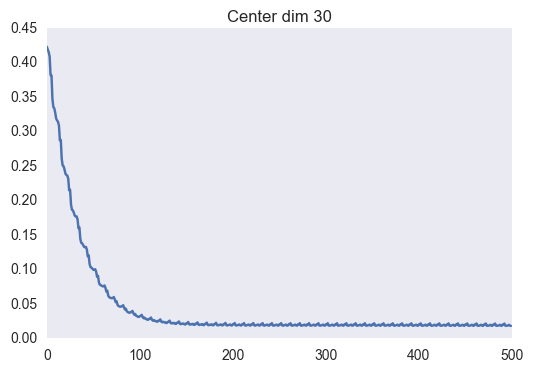

Execution take 25.2862319946


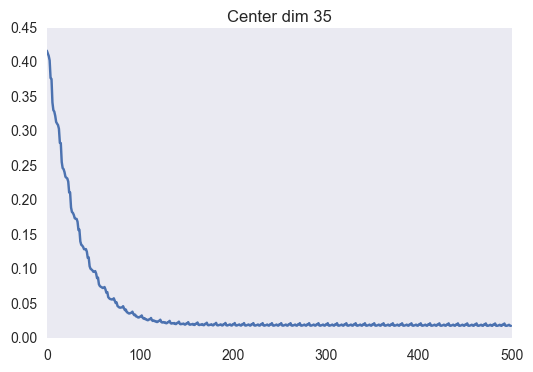

Execution take 23.837692976


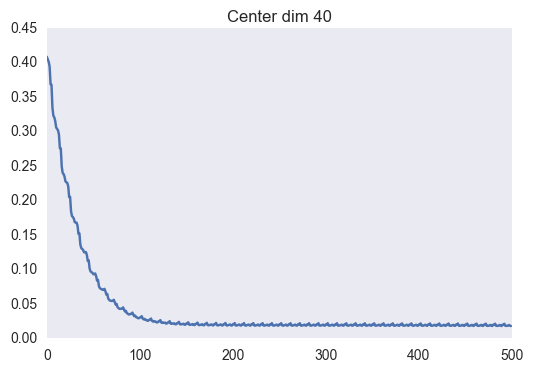

Execution take 22.3735389709


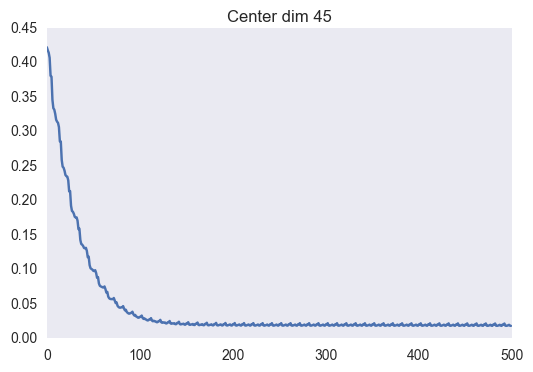

Execution take 24.5516660213


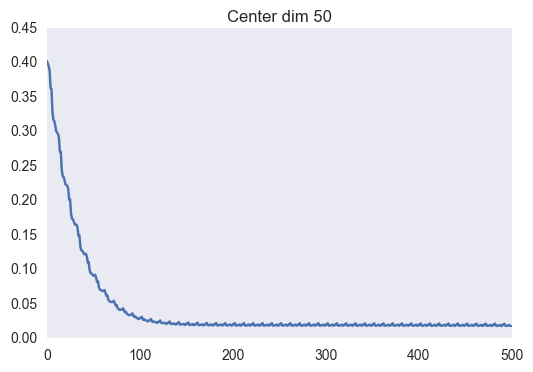

Execution take 26.0874519348


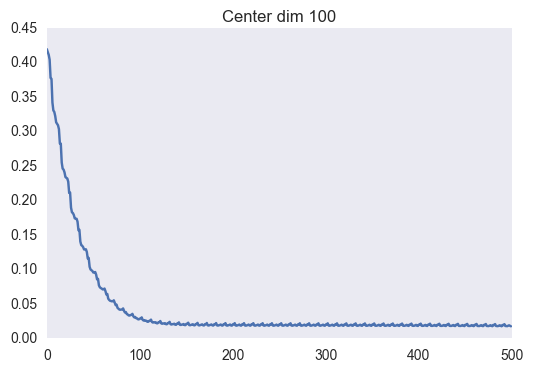

In [17]:
for i, c_dim in enumerate(c_dim_arr):
    train_quality[i], test_quality[i] =  test_autocoder(X_train, X_test, center_dim=c_dim)

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [18]:
print train_quality[5], test_quality[5]

8.64998912811 8.53782367706


<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

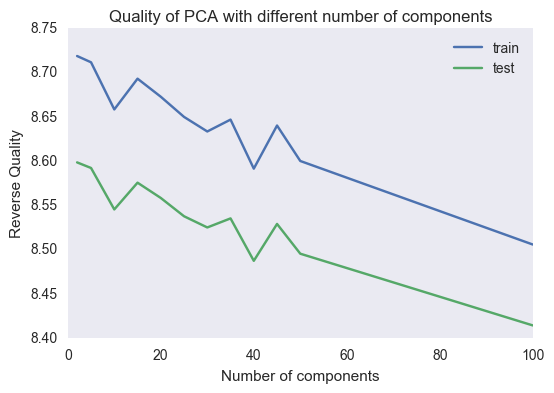

In [19]:
plt.plot(c_dim_arr, train_quality, label = "train")
plt.plot(c_dim_arr, test_quality, label = "test")
plt.title("Quality of PCA with different number of components")
plt.xlabel("Number of components")
plt.ylabel("Reverse Quality")
plt.legend()
plt.show()

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

Видим, что хорошего сжатия не получилось

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

Execution take 28.4387981892


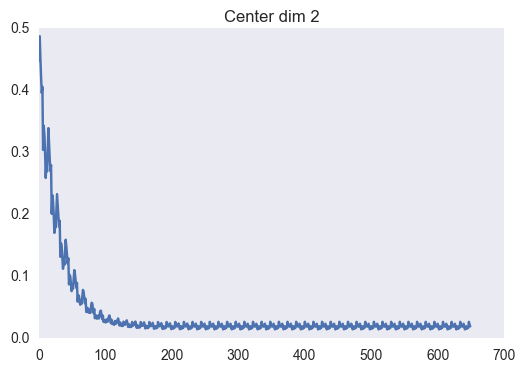

/Users/penzardmitry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/penzardmitry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Image size is 2164x2164


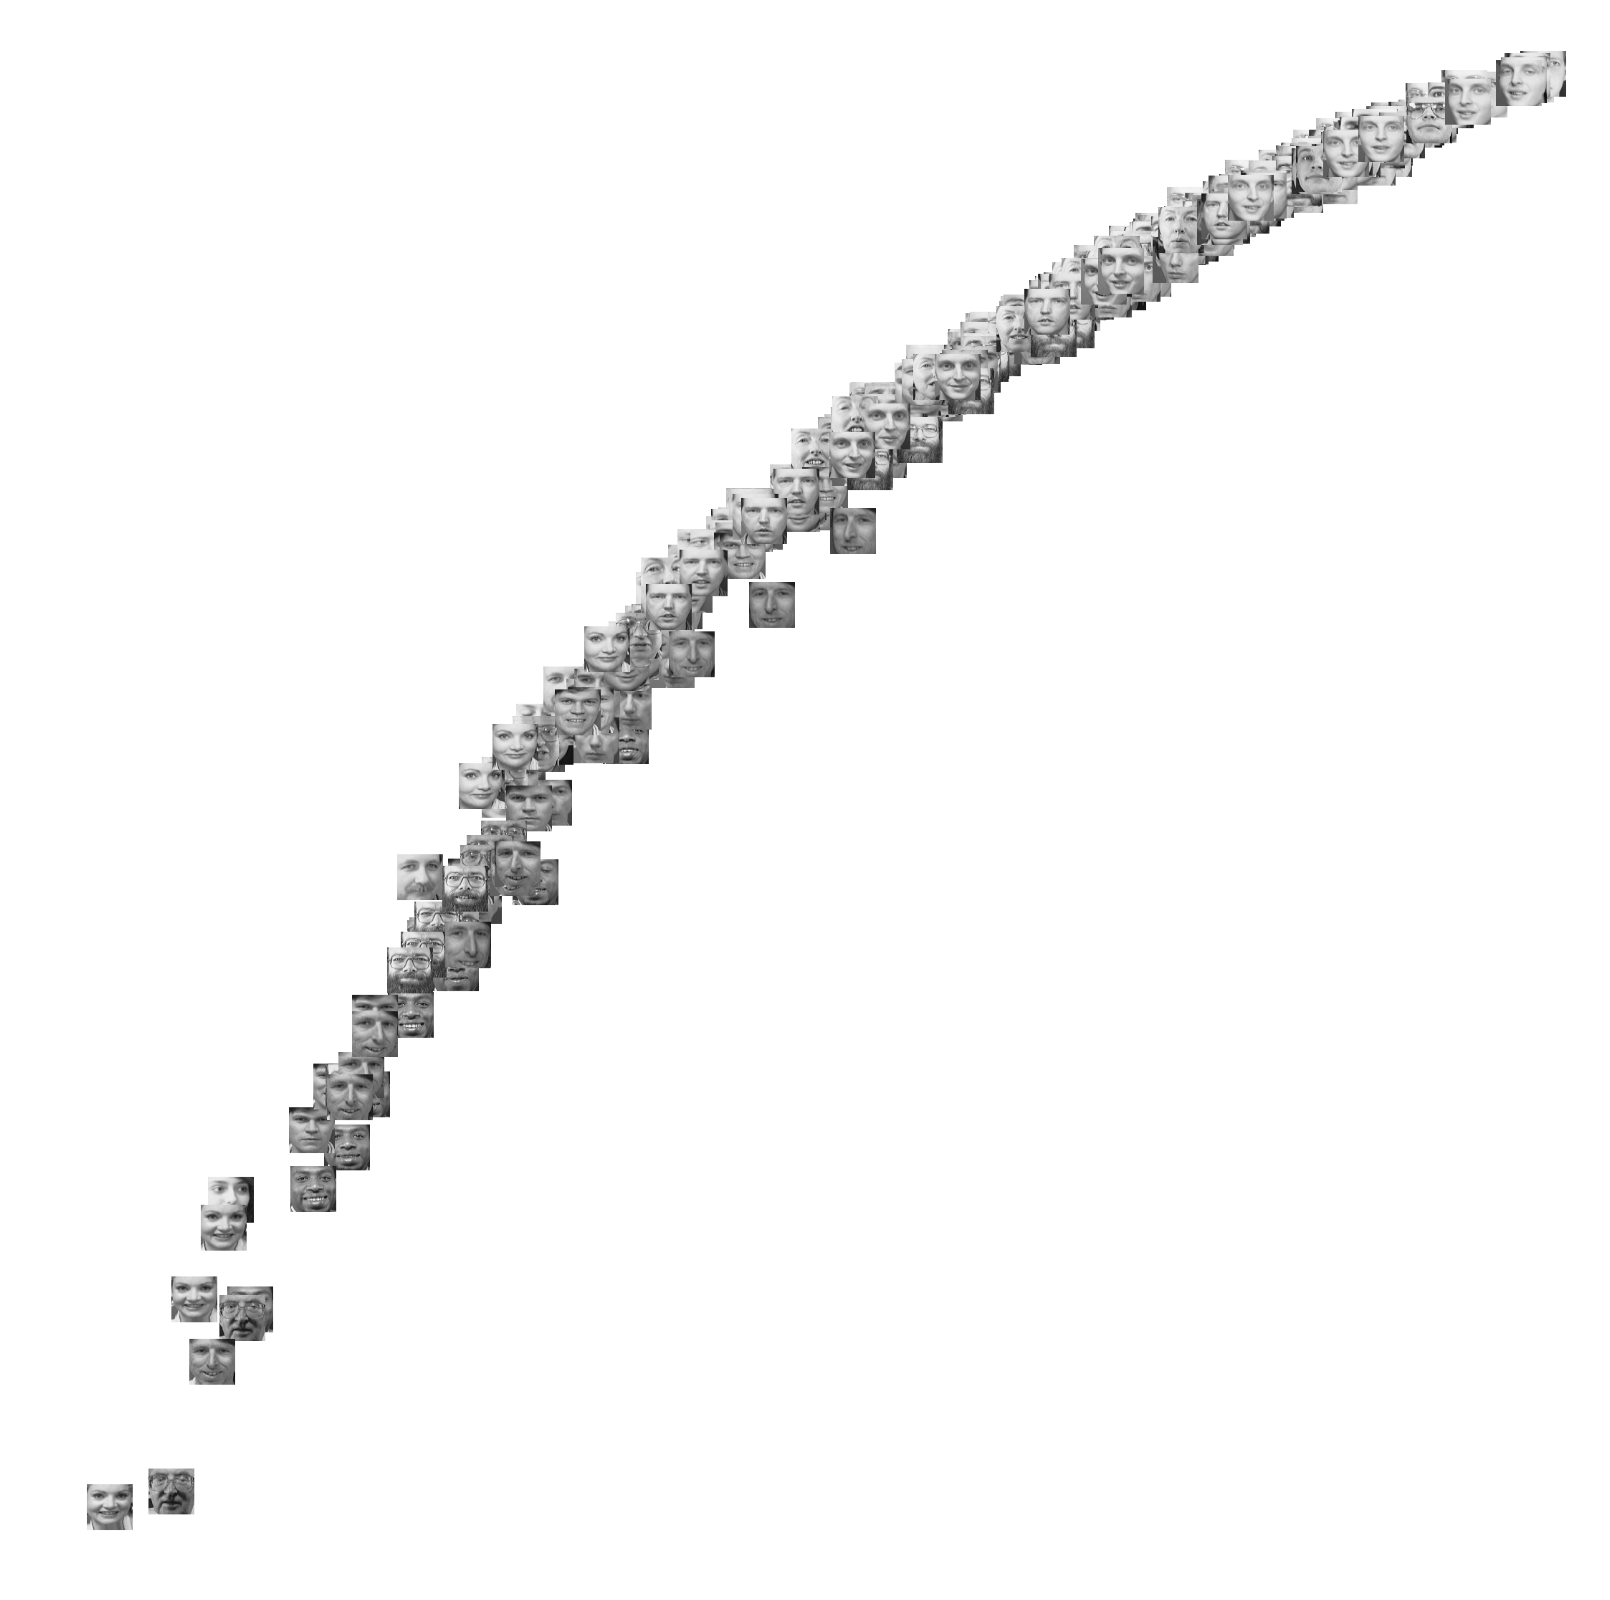

In [20]:
autocoder = get_autocoder(X, X_test, first_dim =200, center_dim=2)
coords = autocoder.coder(Variable(torch.from_numpy(X).\
                                     type(torch.FloatTensor))).data.numpy()
plot_dataset(dataset, coords[:, 0], coords[:, 1])

Не вижу каких-либо кластеров, но изображения выстроились в виде линии, и похожие довольно часто находятся рядом

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: